## Deep troll (Gemidao do Whatsapp) detector



Cansado de ser pego nessas brincadeiras sem graça do Whatsapp? Já ficou em alguma saia justa? 

Vamos colocar o Deep Learning para trabalhar para o bem! O deeptroll usa um modelo de aprendizado profundo que identifica se um áudio contém o Gemidao (AAAWN OOOWN NHAAA AWWWWN AAAAAH).

O modelo usa uma arquitetura RNN-GRU, usando convoluções em espectrogramas de áudio para extrair as features.

Pq o GRU? Direto da Wikipedia:

"Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al.[1] Their performance on polyphonic music modeling and speech signal modeling was found to be similar to that of long short-term memory (LSTM). However, GRUs have been shown to exhibit better performance on smaller datasets.[2] 


In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from spectrogram import *
from td_utils import *
%matplotlib inline
import sys,os,os.path


#from apiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

# Coleta dos dados: Criando o dataset de audios


Começamos construindo um conjunto de dados para o algoritmo. Gostaríamos de detectar o "gemidão" nos áudios do WhatsApp. Portanto, precisamos criar gravações com uma mistura de sons positivos ("AAAWN OOOWN NHAAA AWWWWN AAAAAH") e sons negativos (audios regulares do whatsapp).]




   Colocamos em uma pasta chamada `data` 

In [2]:
# Baixe antes de rodar esssa cell -> 'http://www.potelo.com.br/gemidao-data.tar.gz'
#% tar -xzvf gemidao-data.tar.gz.tar.gz


## Ouvindo os audios   

No diretório raw, você pode encontrar um total de 454 arquivos de áudio whatsapp. Usamos esses arquivos de áudio para sintetizar um conjunto de dados para treinar o modelo. O diretório "troll" contém 1 exemplo positivo de pessoas gritando "AAAWN OOOWN NHAAA AWWWWN AAAAAH". 

O diretório "regular" contém os exemplos regulares de arquivos de áudio do WhatsApp.

Os arquivos de áudio variam de 10 segundos a 5 minutos de clipes de áudio

Execute as células abaixo para ouvir alguns exemplos.


In [3]:
IPython.display.Audio("data/raw_data/audios/1.mp3")

In [4]:
IPython.display.Audio("data/raw_data/audios/4.mp3")


Vamos usar esses 2 tipos. O troll(positivos) e o regular ( audios normais) no nosso treinamento

# Limpeza dos dados

Como as entradas para o modelo serão os espectrogramas, precisamos extrair as features dos arquivos de áudio depois de analisá-los para espectrogramas. 

Como os arquivos de áudio de dados originais tem tamanhos diferentes, eles gerariam tamanhos de entrada diferentes, o que não funcionaria para o nosso modelo. Por esse motivo, recortei os arquivos de áudio para pedaços de 30 segundos.

Para limpar os arquivos de áudio, usei o ffmpeg. Primeiro, precisamos converter os arquivos originais raw_mp3 para o formato wav e cortar os arquivos de áudio para 30 segundos, para ajustar o tamanho de entrada do nosso modelo.

```
import os, subprocess
from os.path import join

ffmpeg = 'C:\\Python37\\Scripts\\ffmpeg.exe'
inputdir = 'E:\\Projetos\\apresentacao_jus\\deeptrolldetector\\data\\30segs'
outputdir = 'E:\\Projetos\\apresentacao_jus\\deeptrolldetector\\data\\converted'


for file_path in os.listdir(inputdir):
    sourceAudio = join(inputdir, file_path)
    destinationAudio = join(outputdir, f"{file_path[:-4]}.wav")
    print(f"Vou processar o {file_path}")
    command = f"{ffmpeg} -t 30 -i {sourceAudio} -acodec pcm_u8 -ar 22050 {destinationAudio}"

    subprocess.call(command)

```


Depois de selecionar os maiores de 30 segundos e processar, ficamos com 239 por estarem ruins ou muito pequenos

(101, 8267)


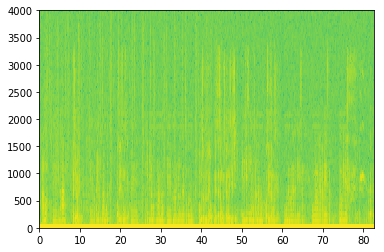

In [5]:
x = graph_spectrogram("./data/train/regular/4.wav")
print(x.shape)
Tx = 8267 # Vamos definir isso como o tamanho do vetor de entradas que representa o tempo
n_freq = 101 # Essa é a altura desse vetor, que simboliza o numero de frequencias que cada pedaco de tmepo tem

Já nossa saida, vamos codificar com um vetor de tamanho $T_y = 2064$ :

In [6]:
Ty = 2064 # Numero de "pedacos" de tempos que vamos colocar como saida

## 1.3 - Gerando um exemplo

Como os o conjunto de dados do gemidão é muito dificil de obter e marcar( acredite, eu tentei!), vou sintetizar os dados de treinamento usando os clipes de áudio de normais e o gemidão

Para sintetizar um exemplo de treinamento, iremos:

- Escolher um clipe de áudio aleatório de 30 segundos
- Aleatoriamente inserir um gemidão nesse audio

Por termos sintetizado o dataset, sabemos exatamente quando, no clipe de 30 segundos, o gemidão aparece. 
Usamos isso como nossos labels de saida no conjunto de treinamento.


In [8]:
# vamos carregar os segmentos usando o pydub 
troll, regulars = load_raw_audio()


print("Regular len: " + str(len(regulars[3])))    # Deve ser aproximadamente 30,000, pois é um pedaço de 30 segundos, artificial.
print("Gemidao len: " + str(len(troll[0])))     # Aproximadamente 5000, pois é o clip troll 

Regular len: 30000
Gemidao len: 4990


**Sobrepondo os gemidões nos audios**:

Dado um audio de 30 segundos e um gemidão, precisamos "adicionar" ou "inserir" gemidão no meio do nosso audio. Para garantir que os segmentos de áudio inseridos no normal não se sobreponham, vamos pegar a locaizaçao de onde colocamos os audios.


**Criar os labels ao mesmo tempo que colocamos o gemidão no audio**:

Para um audio qualquer, nos inicializamos $y^{\langle t \rangle}=0$ para todos os $t$, já que sabemos que o audio não tem nenhum gemidão.

Quando inserimos o gemidão, vamos ter que atualizar os labels para $y^{\langle t \rangle}$, assim os 50 passos após o gemidão, terão o label de 1. Vamos treinar o GRU para detectar quando um gemidão *acabar*.

Para implementar o processo de criaçao do conjunto de treinamento, usaremos as seguintes funções. Todas essas funções usarão um intervalo de discretização de 1 ms, de modo que os 30 segundos de áudio serão discretizados em 30.000 etapas.

1. `get_random_time_segment(segment_ms)` gets a random time segment in our regular audio
2. `is_overlapping(segment_time, existing_segments)` Verifica se o tempo de um segmento se sobrepõe aos outros segmentos
3. `insert_audio_clip(background, audio_clip, existing_times)` Insere um novo segmento de áudio sobre o clipe normal em uma posicao de tempo aleatória, garantindo que segmento de áudio não se sobrepõe aos segmentos existentes
4. `insert_ones(y, segment_end_ms)` insere o valor 1 nos nossos labels depois do segmento

In [9]:
def get_random_time_segment(segment_ms):
    """
    Pega um segmento aleatorio de tamanho segment_ms no audio
    
    Recebe:
    segment_ms -- duracao em ms
    
    Returna:
    segment_time -- tupla contendo (segment_start, segment_end) in ms
    """
    print(segment_ms*2)
    segment_start = np.random.randint(low=0, high=30000-segment_ms*2)   # Vamos ter certeza que nao vamos pegar algo ja no final
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [10]:
def is_overlapping(segment_time, previous_segments):
    """
    Verifica se o tempo de um segmento se sobrepõe aos outros segmentos
    
    Arguments:
    segment_time -- tupla de (segment_start, segment_end) para o novo segmento
    previous_segments -- uma lista de tuplas para os (segment_start, segment_end) segmentos existentes
    
    Returns:
    True se tem overlap, False se nao
    """
    
    segment_start, segment_end = segment_time

    overlap = False
    
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [11]:
def insert_audio_clip(regular, audio_clip, previous_segments):
    """
    
    Insere um novo segmento de áudio sobre o clipe normal em uma posicao de tempo aleatória, garantindo que
     segmento de áudio não se sobrepõe aos segmentos existentes.
    
    Arguments:
    background -- Um audio de 30 segundos.  
    audio_clip -- O gemidao que sera colocado. 
    previous_segments -- Lugares que já colocamos outros gemidoes
    
    Returns:
    new_regular -- O som com o gemidao
    """
    
    # Pegar a duracao em ms
    segment_ms = len(audio_clip)
    
    segment_time = get_random_time_segment(segment_ms)
    
    while (is_overlapping(segment_time, previous_segments)):
        segment_time = get_random_time_segment(segment_ms)

    previous_segments.append(segment_time)
    
    # Vamos colocar o audio por cima. Vamos abaixar em 50 dB o som nesse momento 
    new_regular = regular.overlay(audio_clip, position = segment_time[0], gain_during_overlay=-50.0)
    
    return new_regular, segment_time

9980
9980
Posicao do Segmento:  (15874, 20863)


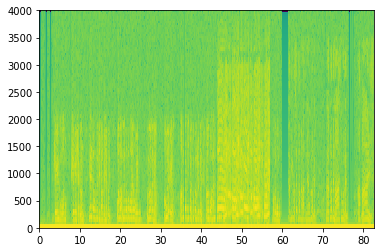

In [12]:
audio_clip, segment_time = insert_audio_clip(regulars[5], troll[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Posicao do Segmento: ", segment_time)
graph_spectrogram("insert_test.wav")
IPython.display.Audio("insert_test.wav")


Finally, we update the labels $y^{\langle t \rangle}$, assuming we just inserted a "troll". In the code below, `y` is a `(1,2064)` dimensional vector, since $T_y = 2064$. 

```
    segment_end_y = int(segment_end_ms * Ty / 30000.0)
```

In [13]:
def insert_ones(y, segment_start_ms, segment_end_ms):
    """
    insere o valor 1 nos nossos labels depois do segmento. Vamos fazer isso durente 50 posicoes
    
    Arguments:
    y -- numpy array de shape (1, Ty), com os labels de Y de treinamento
    segment_end_ms --A posicao inicial do segmento em ms
    segment_end_ms --A posicao final do segmento em ms
    
    Returns:
    y -- os labels atualizados
    """
    
    # Duracao do som de fundo (em time-steps do spectrogram )
    segment_start_y = int(segment_start_ms * Ty / 30000.0)
    segment_end_y = int(segment_end_ms * Ty / 30000.0)
    
    # COlocar 1 depois que o som tocou (y)
    for i in range(segment_end_y+1, segment_end_y+1+50):
        if i < Ty:
            y[0, i] = 1
    
    return y

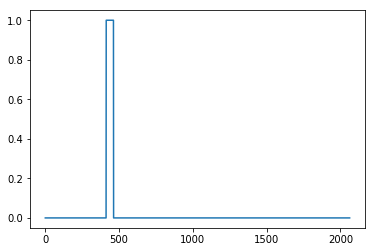

In [15]:
arr1 = insert_ones(np.zeros((1, Ty)), 5000, 6000)
plt.plot(arr1[0])

Finalmente, podemos usar as funcoes `insert_audio_clip` e `insert_ones` para criar um novo exemplo de treinamento.


In [16]:
def create_training_example(regular, trolls, file_name):
    """
    Cria um exemplo de treinamento de um audio com gemidao
    
    Arguments:
    regular -- Um audio de 30 segundos
    troll -- Uma lista de gemidoes
    file_name -- nome_do_arquivo
    
    Returns:
    x -- O espectograma do arquivo
    y -- os labels a cada passo do espectograma
    """
    
    #  Vamos abaixar o som do original ( ficou ruim)
    #regular = regular - 20

    # passo 1: Inicializar y (vector de labels ) com zeros
    y = np.zeros((1, Ty))

    # Passo 2: Inicializar os segmentos
    previous_segments = []
    
    # Selecionar o nosso gemidao( so temos um hoje)
    
    # Inserir o gemidao
    regular, segment_time = insert_audio_clip(regular, trolls[0], previous_segments)
    # Pegar as posicoes que inserimos
    segment_start, segment_end = segment_time[0], segment_time[1]
    # Atualizar os labels em "y"
    print(segment_start)
    print(segment_end)
    y = insert_ones(y, segment_start, segment_end)

    #regular = match_target_amplitude(regular, -20.0)

    # Salvar
    file_handle = regular.export(file_name, format="wav")
    print("O Arquivo ({}) Foi salvo no diretorio.".format(file_name))
    
    # Plotar o novo espectograma
    x = graph_spectrogram(file_name)
    
    return x, y

9980
16538
21527
O Arquivo (train.wav) Foi salvo no diretorio.


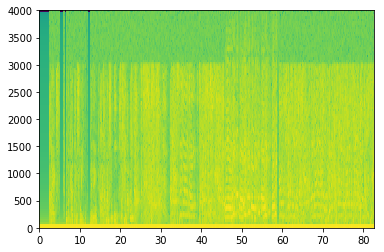

In [17]:
x, y = create_training_example(regulars[100], troll, "train.wav")

Vamos ouvir o exemplo de treinamento que criamos e compará-lo ao espectrograma gerado acima.

In [18]:
IPython.display.Audio("train.wav")

Vamos plotar na regiao associada a vamos ver se bate direitinho com o Audio

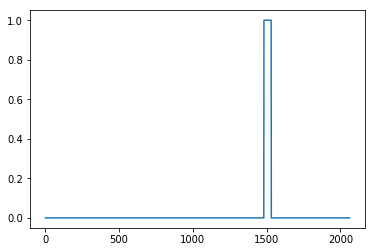

In [19]:
plt.plot(y[0])

## 1.4 - Gerar o conjunto de treino completo

Agora vamos botar um loop para gerar o conjunto inteiro

data/train_generated/0.wav
9980
10274
15263
O Arquivo (data/train_generated/0.wav) Foi salvo no diretorio.
data/train_generated/1.wav
9980
2082
7071
O Arquivo (data/train_generated/1.wav) Foi salvo no diretorio.
data/train_generated/2.wav
9980
6958
11947
O Arquivo (data/train_generated/2.wav) Foi salvo no diretorio.
data/train_generated/3.wav
9980
6956
11945
O Arquivo (data/train_generated/3.wav) Foi salvo no diretorio.
data/train_generated/4.wav
9980
7242
12231
O Arquivo (data/train_generated/4.wav) Foi salvo no diretorio.
data/train_generated/5.wav
9980
18616
23605
O Arquivo (data/train_generated/5.wav) Foi salvo no diretorio.
data/train_generated/6.wav
9980
7841
12830
O Arquivo (data/train_generated/6.wav) Foi salvo no diretorio.
data/train_generated/7.wav
9980
1233
6222
O Arquivo (data/train_generated/7.wav) Foi salvo no diretorio.
data/train_generated/8.wav
9980
7695
12684
O Arquivo (data/train_generated/8.wav) Foi salvo no diretorio.
data/train_generated/9.wav
9980
7759
12748
O A

data/train_generated/76.wav
9980
2547
7536
O Arquivo (data/train_generated/76.wav) Foi salvo no diretorio.
data/train_generated/77.wav
9980
1254
6243
O Arquivo (data/train_generated/77.wav) Foi salvo no diretorio.
data/train_generated/78.wav
9980
7358
12347
O Arquivo (data/train_generated/78.wav) Foi salvo no diretorio.
data/train_generated/79.wav
9980
11737
16726
O Arquivo (data/train_generated/79.wav) Foi salvo no diretorio.
data/train_generated/80.wav
9980
3416
8405
O Arquivo (data/train_generated/80.wav) Foi salvo no diretorio.
data/train_generated/81.wav
9980
19378
24367
O Arquivo (data/train_generated/81.wav) Foi salvo no diretorio.
data/train_generated/82.wav
9980
438
5427
O Arquivo (data/train_generated/82.wav) Foi salvo no diretorio.
data/train_generated/83.wav
9980
5517
10506
O Arquivo (data/train_generated/83.wav) Foi salvo no diretorio.
data/train_generated/84.wav
9980
10326
15315
O Arquivo (data/train_generated/84.wav) Foi salvo no diretorio.
data/train_generated/85.wav
99

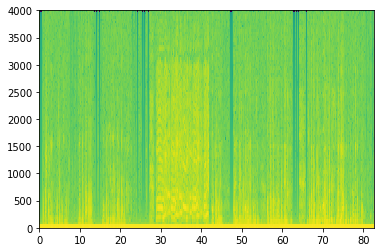

In [20]:
X = []
Y = []

for i, regular in enumerate(regulars):
    print("data/train_generated/{}.wav".format(i))
    x, y = create_training_example(regular, troll, "data/train_generated/{}.wav".format(i))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

## 1.5 - Conjunto de Desenvolvimento

Por agora, eu estou usando os mesmos dados gerados para testar o modelo (não é uma boa abordagem) - Preciso do conjunto rotulado



In [22]:

# Temos isso de dimencao
print(X.shape) 
numero_de_amostras = len(X)

train_size = int(numero_de_amostras * 0.6)

dev_size = numero_de_amostras - train_size

print("Temos {} elementos no total. Vou seperar {} para treino e {} para testes".format(numero_de_amostras, train_size, dev_size))

X_train, X_dev = X[:train_size,:], X[train_size:,:]
Y_train, Y_dev = Y[:train_size,:], Y[train_size:,:]

print(X_train.shape)
print(Y_train.shape)

print(X_dev.shape)
print(Y_dev.shape)


(147, 101, 8267)
Temos 147 elementos no total. Vou seperar 88 para treino e 59 para testes
(88, 101, 8267)
(88, 1, 2064)
(59, 101, 8267)
(59, 1, 2064)


## Modelo

Agora que construímos um conjunto de dados, vamos escrever e treinar um modelo de detectar os gemidoes

O modelo usará camadas convolucionais 1-D, camadas GRU e alguns dropouts.

Essa é uma arquitetura muito simples, sem nenhuma otimização.



In [23]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
import tensorflow as tf
import keras

Using TensorFlow backend.


In [24]:
def model(input_shape):
    """
    Criar o modelo usando o Keras
    
    Argument:
    input_shape -- shape do modelo

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
        
    # Step 1: Conv 1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) # Conv 1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                   # ReLu activation
    X = Dropout(0.8)(X)                                         # dropout (use 0.8)

    # GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                       # Batch normalization
    
    # GRU Layer 
    X = GRU(units = 128, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                       # Batch normalization
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    
    # Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [25]:
model = model(input_shape = (Tx, n_freq))

Vamos dar um print no sumario do modelo para ver se os shapes estão corretos

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8267, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2064, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2064, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 2064, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2064, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 2064, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2064, 128)         0         
__________

A saída da rede é de forma (None, 2064, 1) enquanto a entrada é (None, 8267, 101). O Conv1D reduziu o número de etapas de 8267 no espectrograma para 2064.


## Fit no modelo

Eu já treinei 150 epochs ontem, vamos carregar

In [28]:
model = load_model('data/models/51-batches-150.h5')


Podemos treinar ainda mais o modelo, usando o otimizador Adam e a funcao de loss binary_crossentropy


In [74]:
config = tf.ConfigProto(intra_op_parallelism_threads=16, inter_op_parallelism_threads=16, allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))


# Vamos salvar um checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
# Tensorboard callback
#tbCallback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

In [29]:
model.fit(X_train.reshape(train_size,8267,101), Y_train.reshape(train_size,2064,1), validation_split=0.33, batch_size = 3, epochs=150, callbacks=callbacks_list)#, callbacks=[tbCallback])

NameError: name 'callbacks_list' is not defined

# Salvar o modelo

Vamos Salvar o modelo para acessar depois

In [76]:
model.save('data/models/51-batches-150.h5')

## Testar o modelo

Finalmente, vamos ver como o modelo se comporta no conjunto de desenvolvimento.

In [30]:
loss, acc = model.evaluate(X_dev.reshape(dev_size,8267,101), Y_dev.reshape(dev_size,2064,1))
print("Dev set accuracy = ", acc)

59/59 [==============================] - 8s 128ms/step
Dev set accuracy =  0.9753810359259784


Isso parece muito bom! 

No entanto, a precisão(accuracy) não é uma boa métrica para essa tarefa, uma vez que os labels estao muito desbalanceados para 0s, portanto, uma rede neural que predicte apenas 0 teria um pouco mais de 90% de precisão. 

Devemos usar métricas mais úteis, como F1 ou Precisão / Recall.

Vamos pensar em balancear os modelos!

Por agora, vamos apenas ver como o modelo faz.

# Fazendo Predições

Now that we have built a working model for troll detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

In [31]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    predictions[0][0:8] = 0

    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    print(predictions[0][5:])
    plt.show()
    return predictions

## Testar no conjunto de exemplos

Vamos rodar um pedaco que nao foi usado para treinar a rede, mas eh um exemplo sintetico.

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.02956695]
 [0.02947118]
 [0.02967197]]


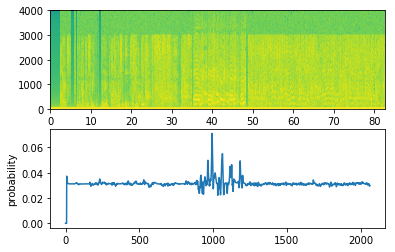

In [33]:
filename = "./data/train_generated/100.wav"
prediction = detect_triggerword(filename)

O modelo funciona!!! Esse elemento nao foi testado. Mas o label nao convergiu como gostariamos. Ainda fica muito proximo de zero.

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.03112224]
 [0.03118516]
 [0.03116197]]


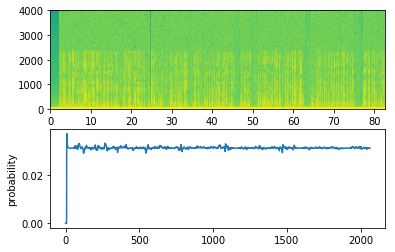

In [34]:
filename  = "./data/train/limpo/241.wav"
prediction = detect_triggerword(filename)

Parece bom, não perfeito. Mas o Y ficou bem flat